In [1]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("Agg") #Needed to save figures
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/hminle/miniconda2/e

In [2]:
from datetime import datetime
from bisect import bisect_right, bisect_left
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

In [3]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

## Load and Explore Data

In [4]:
borrower_df = pd.read_csv('./data/borrower_data.csv')
loan_df = pd.read_csv('./data/loan_data.csv')

In [5]:
borrower_df.head(10)

loan_id  is_first_loan  fully_repaid_previous_loans  \
0   289774              1                          NaN   
1   482590              0                          1.0   
2   135565              1                          NaN   
3   207797              0                          1.0   
4   828078              0                          0.0   
5   423171              1                          NaN   
6   568977              1                          NaN   
7   200139              1                          NaN   
8   991294              0                          1.0   
9   875332              0                          1.0   

   currently_repaying_other_loans  total_credit_card_limit  \
0                             NaN                     8000   
1                             0.0                     4500   
2                             NaN                     6900   
3                             0.0                     1200   
4                             0.0                     6900   
5                             NaN                     6100   
6                             NaN                      600   
7                             NaN                     4000   
8                             0.0                     7000   
9                             0.0                     4300   

   avg_percentage_credit_card_limit_used_last_year  saving_amount  \
0                                             0.49           3285   
1                                             1.03            636   
2                                             0.82           2085   
3                                             0.82            358   
4                                             0.80           2138   
5                                             0.53           6163   
6                                             0.89            305   
7                                             0.57            602   
8                                             0.52           2575   
9                                             0.83            722   

   checking_amount  is_employed  yearly_salary  age  dependent_number  
0             1073            0              0   47                 3  
1             5299            1          13500   33                 1  
2             3422            1          24500   38                 8  
3             3388            0              0   24                 1  
4             4282            1          18100   36                 1  
5             5298            1          29500   24                 1  
6             1456            0              0   50                 2  
7             2757            1          31700   36                 8  
8             2917            1          58900   33                 3  
9              892            1           5400   32                 7

In [6]:
borrower_df.describe()

loan_id  is_first_loan  fully_repaid_previous_loans  \
count  101100.000000  101100.000000                 46153.000000   
mean   499666.826726       0.543492                     0.899291   
std    288662.006929       0.498107                     0.300946   
min        30.000000       0.000000                     0.000000   
25%    250333.750000       0.000000                     1.000000   
50%    499885.000000       1.000000                     1.000000   
75%    749706.250000       1.000000                     1.000000   
max    999987.000000       1.000000                     1.000000   

       currently_repaying_other_loans  total_credit_card_limit  \
count                    46153.000000            101100.000000   
mean                         0.364332              4112.743818   
std                          0.481247              2129.121462   
min                          0.000000                 0.000000   
25%                          0.000000              2700.000000   
50%                          0.000000              4100.000000   
75%                          1.000000              5500.000000   
max                          1.000000             13500.000000   

       avg_percentage_credit_card_limit_used_last_year  saving_amount  \
count                                     94128.000000  101100.000000   
mean                                          0.724140    1799.617616   
std                                           0.186483    1400.545141   
min                                           0.000000       0.000000   
25%                                           0.600000     834.000000   
50%                                           0.730000    1339.000000   
75%                                           0.860000    2409.000000   
max                                           1.090000   10641.000000   

       checking_amount    is_employed  yearly_salary            age  \
count    101100.000000  101100.000000  101100.000000  101100.000000   
mean       3177.150821       0.658675   21020.727992      41.491632   
std        2044.448155       0.474157   18937.581415      12.825570   
min           0.000000       0.000000       0.000000      18.000000   
25%        1706.000000       0.000000       0.000000      32.000000   
50%        2673.000000       1.000000   21500.000000      41.000000   
75%        4241.000000       1.000000   35300.000000      50.000000   
max       13906.000000       1.000000   97200.000000      79.000000   

       dependent_number  
count     101100.000000  
mean           3.864748  
std            2.635491  
min            0.000000  
25%            2.000000  
50%            3.000000  
75%            6.000000  
max            8.000000

In [7]:
loan_df.head(10)

loan_id     loan_purpose        date  loan_granted  loan_repaid
0    19454       investment  2012-03-15             0          NaN
1   496811       investment  2012-01-17             0          NaN
2   929493            other  2012-02-09             0          NaN
3   580653            other  2012-06-27             1          1.0
4   172419         business  2012-05-21             1          0.0
5    77085            other  2012-08-31             0          NaN
6   780070         business  2012-03-14             1          1.0
7   303138  emergency_funds  2012-08-31             1          0.0
8    91475       investment  2012-05-25             1          1.0
9   422392         business  2012-10-25             0          NaN

In [8]:
loan_df.describe()

loan_id   loan_granted   loan_repaid
count  101100.000000  101100.000000  47654.000000
mean   499666.826726       0.471355      0.644353
std    288662.006929       0.499181      0.478714
min        30.000000       0.000000      0.000000
25%    250333.750000       0.000000      0.000000
50%    499885.000000       0.000000      1.000000
75%    749706.250000       1.000000      1.000000
max    999987.000000       1.000000      1.000000

In [9]:
# Left join
joined_df = loan_df.merge(borrower_df, on='loan_id', how='left')

In [10]:
joined_df.head(20)

loan_id     loan_purpose        date  loan_granted  loan_repaid  \
0     19454       investment  2012-03-15             0          NaN   
1    496811       investment  2012-01-17             0          NaN   
2    929493            other  2012-02-09             0          NaN   
3    580653            other  2012-06-27             1          1.0   
4    172419         business  2012-05-21             1          0.0   
5     77085            other  2012-08-31             0          NaN   
6    780070         business  2012-03-14             1          1.0   
7    303138  emergency_funds  2012-08-31             1          0.0   
8     91475       investment  2012-05-25             1          1.0   
9    422392         business  2012-10-25             0          NaN   
10   725653             home  2012-03-14             0          NaN   
11   100545         business  2012-12-20             0          NaN   
12   597342             home  2012-07-04             0          NaN   
13   484791       investment  2012-07-10             0          NaN   
14   502241             home  2012-02-17             0          NaN   
15   502729  emergency_funds  2012-05-02             1          0.0   
16   519314             home  2012-06-11             0          NaN   
17   146962       investment  2012-11-09             0          NaN   
18    11272             home  2012-07-30             1          0.0   
19   402986       investment  2012-04-26             0          NaN   

    is_first_loan  fully_repaid_previous_loans  \
0               1                          NaN   
1               1                          NaN   
2               1                          NaN   
3               0                          1.0   
4               1                          NaN   
5               1                          NaN   
6               0                          1.0   
7               0                          0.0   
8               0                          1.0   
9               0                          1.0   
10              0                          1.0   
11              1                          NaN   
12              1                          NaN   
13              1                          NaN   
14              1                          NaN   
15              0                          1.0   
16              1                          NaN   
17              0                          1.0   
18              1                          NaN   
19              1                          NaN   

    currently_repaying_other_loans  total_credit_card_limit  \
0                              NaN                     8600   
1                              NaN                     5300   
2                              NaN                        0   
3                              0.0                     5400   
4                              NaN                     2900   
5                              NaN                     3000   
6                              0.0                     7800   
7                              1.0                     4300   
8                              0.0                     3900   
9                              1.0                     1000   
10                             1.0                     6800   
11                             NaN                     4700   
12                             NaN                     2800   
13                             NaN                     5100   
14                             NaN                        0   
15                             1.0                     6100   
16                             NaN                     2000   
17                             1.0                     3800   
18                             NaN                     3200   
19                             NaN                     5200   

    avg_percentage_credit_card_limit_used_last_year  saving_amount  \
0                                              0.79           1491 

In [11]:
joined_df.describe()

loan_id   loan_granted   loan_repaid  is_first_loan  \
count  101100.000000  101100.000000  47654.000000  101100.000000   
mean   499666.826726       0.471355      0.644353       0.543492   
std    288662.006929       0.499181      0.478714       0.498107   
min        30.000000       0.000000      0.000000       0.000000   
25%    250333.750000       0.000000      0.000000       0.000000   
50%    499885.000000       0.000000      1.000000       1.000000   
75%    749706.250000       1.000000      1.000000       1.000000   
max    999987.000000       1.000000      1.000000       1.000000   

       fully_repaid_previous_loans  currently_repaying_other_loans  \
count                 46153.000000                    46153.000000   
mean                      0.899291                        0.364332   
std                       0.300946                        0.481247   
min                       0.000000                        0.000000   
25%                       1.000000                        0.000000   
50%                       1.000000                        0.000000   
75%                       1.000000                        1.000000   
max                       1.000000                        1.000000   

       total_credit_card_limit  \
count            101100.000000   
mean               4112.743818   
std                2129.121462   
min                   0.000000   
25%                2700.000000   
50%                4100.000000   
75%                5500.000000   
max               13500.000000   

       avg_percentage_credit_card_limit_used_last_year  saving_amount  \
count                                     94128.000000  101100.000000   
mean                                          0.724140    1799.617616   
std                                           0.186483    1400.545141   
min                                           0.000000       0.000000   
25%                                           0.600000     834.000000   
50%                                           0.730000    1339.000000   
75%                                           0.860000    2409.000000   
max                                           1.090000   10641.000000   

       checking_amount    is_employed  yearly_salary            age  \
count    101100.000000  101100.000000  101100.000000  101100.000000   
mean       3177.150821       0.658675   21020.727992      41.491632   
std        2044.448155       0.474157   18937.581415      12.825570   
min           0.000000       0.000000       0.000000      18.000000   
25%        1706.000000       0.000000       0.000000      32.000000   
50%        2673.000000       1.000000   21500.000000      41.000000   
75%        4241.000000       1.000000   35300.000000      50.000000   
max       13906.000000       1.000000   97200.000000      79.000000   

       dependent_number  
count     101100.000000  
mean           3.864748  
std            2.635491  
min            0.000000  
25%            2.000000  
50%            3.000000  
75%            6.000000  
max            8.000000

In [12]:
# Check No NaN
joined_df.isna().sum()

loan_id                                                0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
loan_repaid                                        53446
is_first_loan                                          0
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year     6972
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
dtype: int64

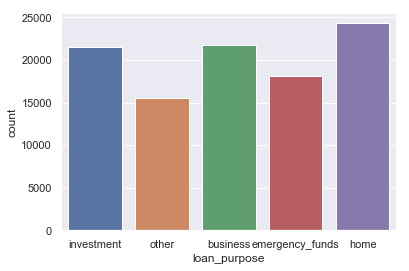

In [13]:
sns.countplot(x='loan_purpose', data=joined_df)

In [14]:
sns.countplot(x='age', data=joined_df)

## Prepare data

In [15]:
def get_quarter(time_str):
    time = datetime.strptime(time_str, '%Y-%m-%d')
    month = time.month
    if month in [1, 2, 3]:
        return "Q1"
    elif month in [4, 5, 6]:
        return "Q2"
    elif month in [7, 8, 9]:
        return "Q3"
    else:
        return "Q4"

In [16]:
joined_df['quarter'] = joined_df.apply(lambda row: get_quarter(row['date']), axis=1)

In [17]:
def get_life_stage(age):
    if age <= 18:
        return 'teen'
    if age > 18 and age <= 30:
        return 'early_adult'
    if age > 30 and age <= 45:
        return 'mature_adult'
    if age > 45 and age < 60:
        return 'late_adult'
    if age > 60:
        return 'old_age'
    return np.nan

In [18]:
joined_df['life_stage'] = joined_df.apply(lambda row: get_life_stage(row['age']), axis=1)

In [19]:
def gain_or_lose(loan_granted, loan_repaid):
    if loan_granted == 0:
        return 'neutral'
    elif loan_repaid == 0:
        return 'lose'
    else:
        return 'gain'

In [20]:
joined_df['gain_or_lose'] = joined_df.apply(lambda row: gain_or_lose(row['loan_granted'], row['loan_repaid']), axis=1)

In [21]:
joined_df.head(10)

loan_id     loan_purpose        date  loan_granted  loan_repaid  \
0     19454       investment  2012-03-15             0          NaN   
1    496811       investment  2012-01-17             0          NaN   
2    929493            other  2012-02-09             0          NaN   
3    580653            other  2012-06-27             1          1.0   
4    172419         business  2012-05-21             1          0.0   
5     77085            other  2012-08-31             0          NaN   
6    780070         business  2012-03-14             1          1.0   
7    303138  emergency_funds  2012-08-31             1          0.0   
8     91475       investment  2012-05-25             1          1.0   
9    422392         business  2012-10-25             0          NaN   
10   725653             home  2012-03-14             0          NaN   
11   100545         business  2012-12-20             0          NaN   
12   597342             home  2012-07-04             0          NaN   
13   484791       investment  2012-07-10             0          NaN   
14   502241             home  2012-02-17             0          NaN   
15   502729  emergency_funds  2012-05-02             1          0.0   
16   519314             home  2012-06-11             0          NaN   
17   146962       investment  2012-11-09             0          NaN   
18    11272             home  2012-07-30             1          0.0   
19   402986       investment  2012-04-26             0          NaN   

    is_first_loan  fully_repaid_previous_loans  \
0               1                          NaN   
1               1                          NaN   
2               1                          NaN   
3               0                          1.0   
4               1                          NaN   
5               1                          NaN   
6               0                          1.0   
7               0                          0.0   
8               0                          1.0   
9               0                          1.0   
10              0                          1.0   
11              1                          NaN   
12              1                          NaN   
13              1                          NaN   
14              1                          NaN   
15              0                          1.0   
16              1                          NaN   
17              0                          1.0   
18              1                          NaN   
19              1                          NaN   

    currently_repaying_other_loans  total_credit_card_limit  \
0                              NaN                     8600   
1                              NaN                     5300   
2                              NaN                        0   
3                              0.0                     5400   
4                              NaN                     2900   
5                              NaN                     3000   
6                              0.0                     7800   
7                              1.0                     4300   
8                              0.0                     3900   
9                              1.0                     1000   
10                             1.0                     6800   
11                             NaN                     4700   
12                             NaN                     2800   
13                             NaN                     5100   
14                             NaN                        0   
15                             1.0                     6100   
16                             NaN                     2000   
17                             1.0                     3800   
18                             NaN                     3200   
19                             NaN                     5200   

    avg_percentage_credit_card_limit_used_last_year  saving_amount  \
0                                              0.79           1491 

In [22]:
joined_df.columns

Index(['loan_id', 'loan_purpose', 'date', 'loan_granted', 'loan_repaid',
       'is_first_loan', 'fully_repaid_previous_loans',
       'currently_repaying_other_loans', 'total_credit_card_limit',
       'avg_percentage_credit_card_limit_used_last_year', 'saving_amount',
       'checking_amount', 'is_employed', 'yearly_salary', 'age',
       'dependent_number', 'quarter', 'life_stage', 'gain_or_lose'],
      dtype='object')

## Feature Selection

In [23]:
imp = SimpleImputer(strategy="median")

In [24]:
joined_df['avg_percentage_credit_card_limit_used_last_year'] = imp.fit_transform(joined_df[['avg_percentage_credit_card_limit_used_last_year']])

In [25]:
X = joined_df[['loan_purpose',
       'is_first_loan', 'fully_repaid_previous_loans',
       'currently_repaying_other_loans', 'total_credit_card_limit',
       'avg_percentage_credit_card_limit_used_last_year', 'saving_amount',
       'checking_amount', 'is_employed', 'yearly_salary',
       'dependent_number', 'quarter', 'life_stage']]

In [26]:
y = joined_df[['gain_or_lose']]

In [27]:
dummy = pd.get_dummies(X[['loan_purpose', 'quarter', 'life_stage']])

In [28]:
dummy.head(10)

loan_purpose_business  loan_purpose_emergency_funds  loan_purpose_home  \
0                      0                             0                  0   
1                      0                             0                  0   
2                      0                             0                  0   
3                      0                             0                  0   
4                      1                             0                  0   
5                      0                             0                  0   
6                      1                             0                  0   
7                      0                             1                  0   
8                      0                             0                  0   
9                      1                             0                  0   

   loan_purpose_investment  loan_purpose_other  quarter_Q1  quarter_Q2  \
0                        1                   0           1           0   
1                        1                   0           1           0   
2                        0                   1           1           0   
3                        0                   1           0           1   
4                        0                   0           0           1   
5                        0                   1           0           0   
6                        0                   0           1           0   
7                        0                   0           0           0   
8                        1                   0           0           1   
9                        0                   0           0           0   

   quarter_Q3  quarter_Q4  life_stage_early_adult  life_stage_late_adult  \
0           0           0                       0                      0   
1           0           0                       0                      0   
2           0           0                       0                      0   
3           0           0                       0                      1   
4           0           0                       0                      0   
5           1           0                       0                      0   
6           0           0                       0                      1   
7           1           0                       0                      1   
8           0           0                       1                      0   
9           0           1                       0                      0   

   life_stage_mature_adult  life_stage_old_age  life_stage_teen  
0                        1                   0                0  
1                        1                   0                0  
2                        0                   0                0  
3                        0                   0                0  
4                        1                   0                0  
5                        1                   0                0  
6                        0                   0                0  
7                        0                   0                0  
8                        0                   0                0  
9                        1                   0                0

In [29]:
X_concat_dummy = pd.concat([X, dummy], axis=1)

In [30]:
X_concat_dummy = X_concat_dummy.drop(columns=['loan_purpose', 'quarter', 'life_stage'])

In [31]:
len(X_concat_dummy.columns)

24

In [32]:
X_concat_dummy.head(10)

is_first_loan  fully_repaid_previous_loans  currently_repaying_other_loans  \
0              1                          NaN                             NaN   
1              1                          NaN                             NaN   
2              1                          NaN                             NaN   
3              0                          1.0                             0.0   
4              1                          NaN                             NaN   
5              1                          NaN                             NaN   
6              0                          1.0                             0.0   
7              0                          0.0                             1.0   
8              0                          1.0                             0.0   
9              0                          1.0                             1.0   

   total_credit_card_limit  avg_percentage_credit_card_limit_used_last_year  \
0                     8600                                             0.79   
1                     5300                                             0.52   
2                        0                                             0.73   
3                     5400                                             0.52   
4                     2900                                             0.76   
5                     3000                                             0.82   
6                     7800                                             0.30   
7                     4300                                             1.02   
8                     3900                                             0.65   
9                     1000                                             1.09   

   saving_amount  checking_amount  is_employed  yearly_salary  \
0           1491             6285            1          45200   
1            141             5793            0              0   
2            660             3232            1          26500   
3           3345             2764            1          15800   
4           1050             3695            1          34800   
5           1028             3269            0              0   
6           4206             4368            1          51100   
7            886             1597            1          15000   
8           1837             3795            1          12000   
9            134             1408            0              0   

   dependent_number       ...         loan_purpose_other  quarter_Q1  \
0                 7       ...                          0           1   
1                 5       ...                          0           1   
2                 4       ...                          1           1   
3                 4       ...                          1           0   
4                 4       ...                          0           0   
5                 3       ...                          1           0   
6                 2       ...                          0           1   
7                 2       ...                          0           0   
8                 1       ...                          0           0   
9                 2       ...                          0           0   

   quarter_Q2  quarter_Q3  quarter_Q4  life_stage_early_adult  \
0           0           0           0                       0   
1           0           0           0                       0   
2           0           0           0                       0   
3           1           0           0                       0   
4           1           0           0                       0   
5           0           1           0                       0   
6           0           0           0                       0   
7           0           1           0                       0   
8           1           0           0                       1   
9           0           0           1                       0   

   life_stage_la

In [33]:
X_concat_dummy = X_concat_dummy.fillna(0)

In [34]:
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing

In [35]:
le = preprocessing.LabelEncoder()

In [36]:
y_le = le.fit_transform(y)

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
y_le

array([2, 2, 2, ..., 0, 0, 2])

In [38]:
# create a base classifier used to evaluate a subset of attributes
lregression = LogisticRegression()
svc = SVC(kernel="linear", C=1)
nSelectedFeature = 10
rfe = RFE(lregression, nSelectedFeature)

In [39]:
rfe = rfe.fit_transform(X_concat_dummy, y_le)

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/hminle/mini

In [41]:
from sklearn.feature_selection import f_regression
ffs = f_regression(X_concat_dummy, y_le)
rankinfo = ffs[0]
print(rankinfo)

[6.60925101e-02 3.74252737e+00 2.10775158e+03 7.70149300e+03
 2.96302185e+03 8.19087064e+03 8.01668306e+03 3.58157151e+04
 2.93570571e+04 5.26410914e+02 2.25462835e+02 5.30212502e+02
 1.69643528e+01 1.80161180e+02 1.63368028e+02 6.19924911e+00
 4.00884050e-02 4.19905851e-01 2.69095572e+00 1.11637117e+00
 1.62539394e-02 8.23832971e-01 6.00024067e-01 2.31600713e+00]


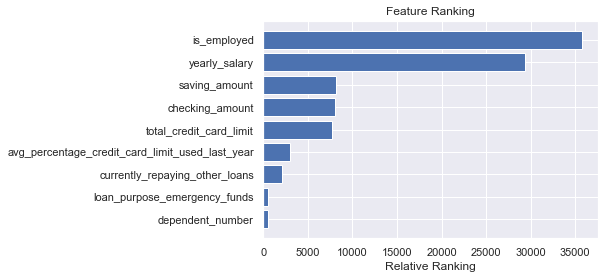

In [42]:
features = X_concat_dummy.columns
indices = np.argsort(rankinfo)[-(nSelectedFeature-1):]
plt.title('Feature Ranking')
plt.barh(range(len(indices)), rankinfo[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Ranking')
plt.show()

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc.fit(X_concat_dummy, y_le)
print(etc.feature_importances_)

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.00647085 0.00693926 0.01772605 0.13650642 0.11402332 0.1364633
 0.13220355 0.1303609  0.130029   0.06999776 0.00599936 0.00510273
 0.0067145  0.0068087  0.00539433 0.01082933 0.01182225 0.01103698
 0.01096733 0.01068756 0.01185775 0.01192073 0.00766216 0.00247585]


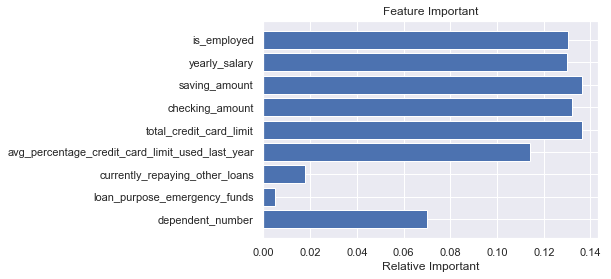

In [44]:
features = X_concat_dummy.columns
indices = np.argsort(rankinfo)[-(nSelectedFeature-1):]
plt.title('Feature Important')
plt.barh(range(len(indices)), etc.feature_importances_[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Important')
plt.show()

## Build predict model

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_concat_dummy, y_le, test_size=0.2, random_state=random.seed(2016))

In [46]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [47]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.64


In [55]:
from sklearn.ensemble import RandomForestClassifier
regr = RandomForestClassifier(n_estimators=100)

In [56]:
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(regr.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


In [51]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)

In [54]:
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(gbc.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


In [57]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(ada.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.65


### Draw feature important of GradientBoosting

In [59]:
# Plot feature importance
feature_importance = gbc.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_concat_dummy.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Draw confusion matrix

In [60]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[5183  337  560]
 [ 182 2248  997]
 [2151 1053 7509]]


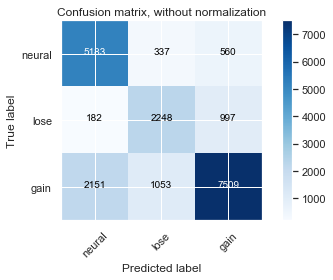

In [64]:
y_pred = gbc.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['neural', 'lose', 'gain'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

## Report

The bank profit: gain - lose = 7286

my model: gain - lose = 5261

My model is not good than the bank

- *is_employed* is the most important feature to predict the borrower behaviour. I think the bank consider who is employed have monthly salary to pay back the loan
- Other variables that I think we should add to the dataset are "credit_card_using_amount_in_one_month"  